In [1]:
import cellcharter as cc
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.colors import ListedColormap
import pandas as pd
import seaborn as sns
import scanpy as sc
import anndata as ad
import squidpy as sq
import os
import json

/Users/lukashat/miniforge3/envs/cellcharter_scarches/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
 captum (see https://github.com/pytorch/captum).


In [4]:
extension = 'svg'
save_path = f'/Users/lukashat/Documents/PhD_Schapiro/Projects/Myeloma_Standal/paper/plots/figures/figure_5/{extension}/'
save_path_supp = f'/Users/lukashat/Documents/PhD_Schapiro/Projects/Myeloma_Standal/paper/plots/figures/suppl_figure_5/{extension}/'
plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi'] = 300
adata = ad.read_h5ad("/Users/lukashat/Documents/PhD_Schapiro/Projects/Myeloma_Standal/results/standard/adatas/cells_final.h5ad")
with open('/Users/lukashat/Documents/PhD_Schapiro/Projects/Myeloma_Standal/github/myeloma_standal/src/Paper/figure_plots/neighborhood_color_map.json', 'r') as f:
    neighborhood_color_map = json.load(f)
with open('/Users/lukashat/Documents/PhD_Schapiro/Projects/Myeloma_Standal/github/myeloma_standal/src/Paper/figure_plots/phenotype_color_map.json', 'r') as f:
    phenotype_color_map = json.load(f)
with open('/Users/lukashat/Documents/PhD_Schapiro/Projects/Myeloma_Standal/github/myeloma_standal/src/Paper/figure_plots/disease_color_map.json', 'r') as f:
    disease_color_map = json.load(f)
with open('/Users/lukashat/Documents/PhD_Schapiro/Projects/Myeloma_Standal/github/myeloma_standal/src/Paper/figure_plots/disease3_color_map.json', 'r') as f:
    disease3_color_map = json.load(f)
neighborhood_colors = [neighborhood_color_map[cat] for cat in list(adata.obs['cellcharter_CN'].cat.categories)]
neighborhood_colors = ListedColormap(neighborhood_colors)
phenotype_colors = [phenotype_color_map[cat] for cat in list(adata.obs['Phenotype4'].cat.categories)]
phenotype_colors = ListedColormap(phenotype_colors)
disease_colors = [disease_color_map[cat] for cat in list(adata.obs['disease2'].cat.categories)]
disease_colors = ListedColormap(disease_colors)
disease3_colors = [disease3_color_map[cat] for cat in list(adata.obs['disease3'].cat.categories)]
disease3_colors = ListedColormap(disease3_colors)

In [5]:
md = pd.read_csv('/Users/lukashat/Documents/PhD_Schapiro/Projects/Myeloma_Standal/metadata/metadata.csv')
md = md[md['Cohort'].isin(['B', 'UB'])]
md = md.dropna(subset=['Days to progression (PFS)']).reset_index(drop=True)
adata = adata[adata.obs['patient_ID'].isin(md['IMC label'])]
adata.obs['PFS_group'] = adata.obs['patient_ID'].map(md.set_index('IMC label')['Short_long PFS (< or >  2 yrs)'])
adata.obs['PFS_group'] = adata.obs['PFS_group'].astype('category')

/var/folders/ry/jl4ll0zx1l709rh4r7_0cq6r0000gn/T/ipykernel_79514/3649841793.py:5: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['PFS_group'] = adata.obs['patient_ID'].map(md.set_index('IMC label')['Short_long PFS (< or >  2 yrs)'])


In [6]:
pfs_color_map = {'short_PFS': sns.color_palette('dark')[6], 'long_PFS': sns.color_palette('dark')[8]}

# Diff. NBH enrichment between PFS groups

In [7]:
cc.gr.diff_nhood_enrichment(
    adata,
    cluster_key=f'cellcharter_CN',
    condition_key='PFS_group',
    library_key='image_ID',
)

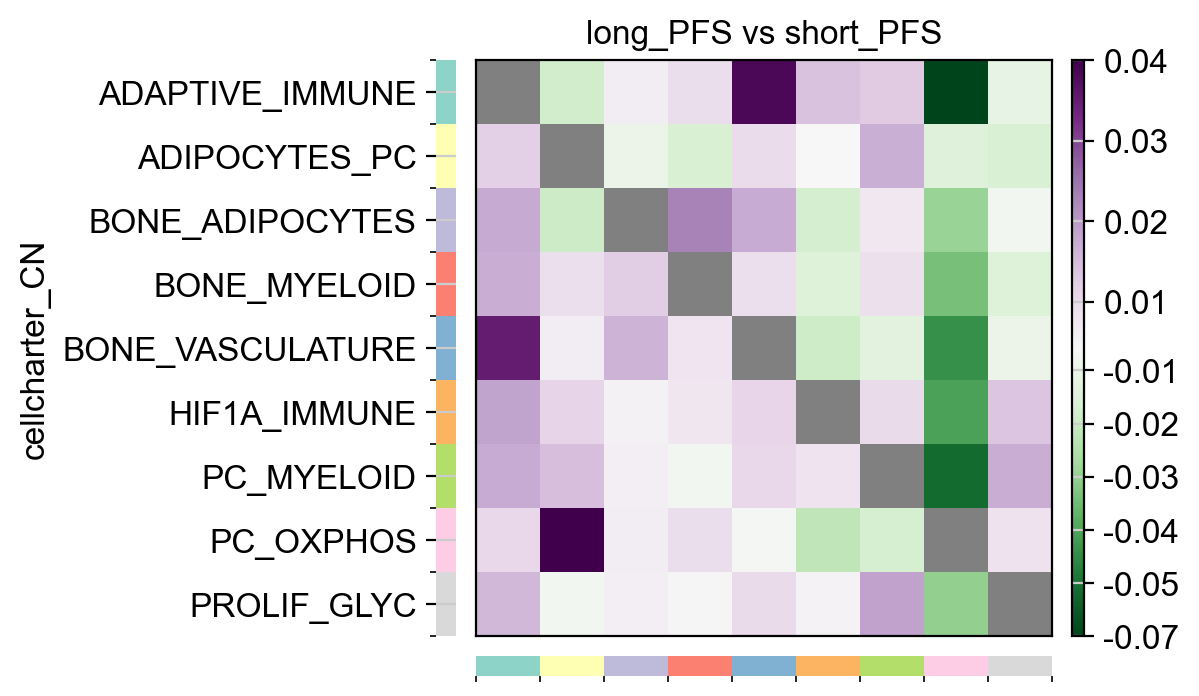

In [9]:
cc.pl.diff_nhood_enrichment(
    adata,
    cluster_key=f'cellcharter_CN',
    condition_key='PFS_group',
    condition_groups=['long_PFS', 'short_PFS'],
    figsize=(4,4),
    fontsize=12,
    save = os.path.join(save_path_supp, f'diff_nhood_enrichment.{extension}')
)

# Lets take specific cellcharter nbh enrichment scores per patient

In [ ]:
cc.gr.nhood_enrichment(
    adata,
    cluster_key='cellcharter_CN',
    pvalues=True,
    n_jobs=8,
    n_perms=250
)

In [ ]:
cc.pl.nhood_enrichment(
    adata,
    cluster_key='cellcharter_CN',
    annotate=True,
    figsize=(4,4),
    significance=0.05,
    fontsize=12,
    vmax=0.03208789256832183,
    vmin=-0.03208789256832183
)

In [ ]:
score_categories = ['adaptive_immune*bone_vasculature', 'adaptive_immune*focal_pc_oxphos', 'focal_pc_oxphos*stroma_adipocyte',
                    'pc_myeloid*focal_pc_oxphos', 'bone_vasculature*focal_pc_oxphos', 'hypoxic_immune*focal_pc_oxphos']
def add_patient(patient_id):
    score_dict[patient_id] = {category: [] for category in score_categories}
score_dict = {}

In [ ]:
for patient in md['IMC label'].unique():
    add_patient(patient)
    adata_subset = adata[adata.obs['patient_ID'] == patient].copy()
    cc.gr.nhood_enrichment(
        adata_subset,
        cluster_key='cellcharter_CN',
    )
    for category in score_categories:
        index_nbh1, index_nbh2 = category.split('*')
        score_dict[patient][category] = pd.DataFrame(adata_subset.uns['cellcharter_CN_nhood_enrichment']['enrichment']).loc[index_nbh1, index_nbh2]
    del adata_subset


In [ ]:
df = pd.DataFrame(score_dict).T
df['patient_ID'] = df.index
pfs_mappping = adata.obs[['PFS_group', 'patient_ID']].drop_duplicates()
pfs_mappping.set_index('patient_ID', inplace=True)
df['pfs'] = df['patient_ID'].map(pfs_mappping['PFS_group'])
df.dropna(inplace=True)
df.sort_values('pfs', inplace=True)
df.set_index('patient_ID', inplace=True)
df

In [ ]:
df[df['pfs'] == 'short_PFS']

In [ ]:
df.to_csv('/Users/lukashat/Documents/PhD_Schapiro/Projects/Myeloma_Standal/github/myeloma_standal/src/downstream/clinical_correlation/nhood_enrichment_patients.csv')

In [ ]:
adata_subset.uns['cellcharter_CN_nhood_enrichment']['enrichment']

In [ ]:
index_nbh1, index_nbh2

In [ ]:
score_categories = ['adaptive_immune*bone_vasculature', 'adaptive_immune*focal_pc_oxphos', 'focal_pc_oxphos*stroma_adipocyte',
                    'pc_myeloid*focal_pc_oxphos', 'bone_vasculature*focal_pc_oxphos', 'hypoxic_immune*focal_pc_oxphos']
def add_image(image_id):
    score_dict[image_id] = {category: [] for category in score_categories}
score_dict = {}
for image_id in adata.obs['image_ID'].unique():
    add_image(image_id)
    adata_subset = adata[adata.obs['image_ID'] == image_id].copy()
    cc.gr.nhood_enrichment(
        adata_subset,
        cluster_key='cellcharter_CN',
    )
    for category in score_categories:
        index_nbh1, index_nbh2 = category.split('*')

        if (index_nbh1 not in adata_subset.uns['cellcharter_CN_nhood_enrichment']['enrichment'].index) or (index_nbh2 not in adata_subset.uns['cellcharter_CN_nhood_enrichment']['enrichment'].index):
            score_dict[image_id][category] = np.nan

        else: 
            score_dict[image_id][category] = pd.DataFrame(adata_subset.uns['cellcharter_CN_nhood_enrichment']['enrichment']).loc[index_nbh1, index_nbh2]
    del adata_subset


In [ ]:
df = pd.DataFrame(score_dict).T
df['image_ID'] = df.index
pfs_mappping = adata.obs[['PFS_group', 'image_ID']].drop_duplicates()
pfs_mappping.set_index('image_ID', inplace=True)
df['pfs'] = df['image_ID'].map(pfs_mappping['PFS_group'])
df.dropna(inplace=True)
df.sort_values('pfs', inplace=True)
df.set_index('image_ID', inplace=True)
df

In [ ]:
df.to_csv('/Users/lukashat/Documents/PhD_Schapiro/Projects/Myeloma_Standal/github/myeloma_standal/src/downstream/clinical_correlation/nhood_enrichment_images.csv')